# Import necessary libraries/modules

In [1]:
# Import necessary libraries/functions/modules
import nltk
import pandas as pd
import gensim.downloader
import matplotlib.pyplot as plt
from gensim.models import Word2Vec
from nltk.tokenize import word_tokenize, sent_tokenize
nltk.download('punkt')  # Download NLTK resources (if not done previously)

[nltk_data] Downloading package punkt to /root/nltk_data...
[nltk_data]   Unzipping tokenizers/punkt.zip.


True

# Functions

In [2]:
# Function used to evaluate the model:
def model_evaluator(model, dataset):
    # Prepare the output data
    output_data = []

    # Iterate through each row in the dataset
    for index, row in dataset.iterrows():
        # Extract the question and answer words from the current row
        question_word = row['question']
        answer_word = row['answer']

        # Generate a list of guess words from the current row. This means that
        # for each row, it takes the values from the columns labeled "0", "1",
        # "2", and "3" as the guess words
        guess_words = [row[str(i)] for i in range(4)]

        # Check if the question word is in the model
        if question_word in model:
            # Initialize a list to store similarities between question and guess words
            similarities = []

            # Loop through each guess word
            for guess_word in guess_words:
                # Check if the guess word is in the model
                if guess_word in model:
                    # Calculate the similarity between question and guess word using the similarity method from Gensim
                    similarity = model.similarity(question_word, guess_word)
                    # Store the guess word and its similarity score
                    similarities.append((guess_word, similarity))

            # Determine the best guess based on the highest similarity score
            if similarities:
                best_guess, _ = max(similarities, key=lambda x: x[1])
                # Label as "correct" if the best guess matches the answer word
                label = 'correct' if best_guess == answer_word else 'wrong'
            else:
                # If no valid guesses, set best guess to None and label as "guess"
                best_guess = None
                label = 'guess'
        else:
            # If question word is not in the model, no guess can be made
            best_guess = None
            label = 'guess'

        # Append the results to the output data
        output_data.append([question_word, answer_word, best_guess, label])
    return output_data

In [3]:
# Function used to transform the data into a DataFrame and CSV file:
def output_df(output_data, model_name):
    # Convert the output data to a DataFrame and save the output to a CSV file
    output_df = pd.DataFrame(output_data, columns=['question-word', 'answer-word', 'guess-word', 'label'])
    output_df.to_csv(model_name + "-details.csv", index=False)
    return output_df

In [4]:
# Function used to compute the metrics:
def compute_accuracy(output_df):
    # 1. Count the number of correct (C) and non-guess labels (V)
    C = (output_df['label'] == 'correct').sum()
    V = (output_df['label'] != 'guess').sum()

    # 2. Calculate the accuracy
    if V:
        accuracy = C / V
    else:
        accuracy = 0
    return C, V, accuracy

In [7]:
# Function used to save all the details of several models in a dictionary:
def save_data(analysis_dic, model_name, model, output_data):
    C, V, accuracy = compute_accuracy(output_df(output_data, model_name))
    new_entry = {
        'model_name': model_name,
        'vocabulary_size': len(model.key_to_index),
        'correct_labels': C,
        'answered_questions': V,
        'accuracy': accuracy
    }
    analysis_dic[model_name] = new_entry

In [5]:
# Preprocess function to tokenize and split sentences:
def preprocess_books(books):
    sentences = []
    for book in books:
        with open(book, 'r', encoding='utf-8') as file:
            text = file.read()
            # Tokenize into sentence
            # .extend removes duplicates from the vocabulary list
            sentences.extend(sent_tokenize(text))
    return [word_tokenize(sentence.lower()) for sentence in sentences]

# Tasks

## Task 1

In [8]:
# Load the pretrained embedding model:
model_name = "word2vec-google-news-300"
model = gensim.downloader.load(model_name)

# Load the Synonym Test dataset:
dataset = pd.read_csv("A2-Dataset/synonym.csv")

# Save the data:
analysis_dic = {}
save_data(analysis_dic, model_name, model, model_evaluator(model, dataset))

# Convert dictionary to DataFrame:
analysis_df = pd.DataFrame.from_dict(analysis_dic, orient="index")

# Save the DataFrame to a CSV file:
analysis_df.to_csv('analysis.csv', index=False, header=False)

## Task 2

In [ ]:
# Load the pretrained embedding models:
model_name1 = "glove-wiki-gigaword-300"
model_name2 = "fasttext-wiki-news-subwords-300"
model_name3 = "glove-twitter-100"
model_name4 = "glove-twitter-200"

model1 = gensim.downloader.load(model_name1)
model2 = gensim.downloader.load(model_name2)
model3 = gensim.downloader.load(model_name3)
model4 = gensim.downloader.load(model_name4)

# Save the data:
save_data(analysis_dic, model_name1, model1, model_evaluator(model1, dataset))
save_data(analysis_dic, model_name2, model2, model_evaluator(model2, dataset))
save_data(analysis_dic, model_name3, model3, model_evaluator(model3, dataset))
save_data(analysis_dic, model_name4, model4, model_evaluator(model4, dataset))

# Convert dictionary to DataFrame:
analysis_df = pd.DataFrame.from_dict(analysis_dic, orient="index")

# Save the DataFrame to a CSV file:
analysis_df.to_csv('analysis.csv', index=False, header=False)

## Task 3

In [10]:
# Declare variables that will be used in the task, such as the books, the window
# sizes or the embedding sizes:
books = ['Books/agnes_grey.txt', 'Books/frankestein.txt', 'Books/jane_eyre.txt',
         'Books/little_women.txt', 'Books/mrs_dalloway.txt', 'Books/pride_and_prejudice.txt',
         'Books/regiment_of_women.txt', 'Books/wuthering_heights.txt']
window_sizes = [100, 200]
embedding_sizes = [100, 300]

for window_size in window_sizes:
    for embedding_size in embedding_sizes:
        model_name = f'Model_W{window_size}_E{embedding_size}'

        # Preprocess books:
        sentences = preprocess_books(books)

        # Train Word2Vec model:
        model = Word2Vec(sentences, vector_size = embedding_size, window = window_size, min_count = 1, workers = 4)

        # Save details to CSV:
        save_data(analysis_dic, model_name, model.wv, model_evaluator(model.wv, dataset))

        # Convert dictionary to DataFrame:
        analysis_df = pd.DataFrame.from_dict(analysis_dic, orient="index")

        # Save the DataFrame to a CSV file:
        analysis_df.to_csv('analysis.csv', index=False, header=False)

## Comparison of the performance of models

Now it is time to compare all the models between them. In order to do this, we decided to compare their performances with a random baseline and with a human-gold standard.

The random baseline will be represented in the graph by a red line. It is the expected accuracy from a model that only has the ability to randomly choose on of the given possible answers. In our case since we are operating one a bag of words with 4 synonym possibilities (only one of which is correct), the random baseline sits at 25%. It is the baseline to compare our models too because we want to guarantee our results are better than simply guessing and, more importantly, quantify how better they are. So we can see that clearly the bottom 3 models are barely better than guessing and cannot be considered to have learned from the dataset.

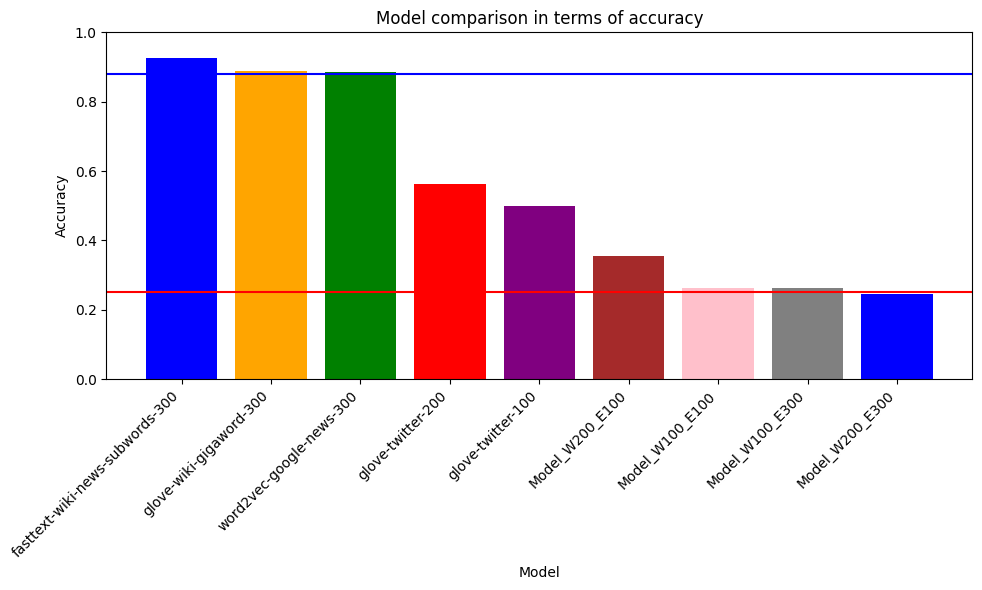

In [34]:
# Load analysis results from the CSV file:
analysis_df = pd.read_csv('analysis.csv', header=None, names=['model_name', 'vocabulary_size', 'correct_labels', 'answered_questions', 'accuracy'])

# Sort the DataFrame by accuracy in descending order:
analysis_df = analysis_df.sort_values(by='accuracy', ascending=False)

# Plot the bar graph:
plt.figure(figsize=(10, 6))
plt.bar(analysis_df['model_name'], analysis_df['accuracy'], color=['blue', 'orange', 'green', 'red', 'purple', 'brown', 'pink', 'gray'])
plt.xlabel('Model')
plt.ylabel('Accuracy')
plt.title('Model comparison in terms of accuracy')
plt.ylim(0, 1)  # Set y-axis limit to better visualize differences

# Adding two solid horizontal lines: one at y=0.25 to mark the random baseline
# and another one at y=0.88 to mark the human-gold standard.
plt.axhline(y=0.25, color='red', linestyle='-')
plt.axhline(y=0.88, color='blue', linestyle='-')

plt.xticks(rotation=45, ha='right')  # Rotate x-axis labels for better readability
plt.tight_layout()

# Save the plot as an image (optional):
plt.savefig('model_comparison_accuracy.png')

# Display the plot:
plt.show()

In [35]:
analysis_df['embedding_size'] = [300, 300, 300, 200, 100, 100, 100, 300, 300]

In [36]:
analysis_df.columns = ['Model', 'Vocabulary Size', 'Correct Predictions', 'Total Instances', 'Accuracy', 'Embedding Size']
analysis_df

,Model,Vocabulary Size,Correct Predictions,Total Instances,Accuracy,Embedding Size
2,fasttext-wiki-news-subwords-300,999999,74,80,0.925000,300
1,glove-wiki-gigaword-300,400000,71,80,0.887500,300
0,word2vec-google-news-300,3000000,70,79,0.886076,300
4,glove-twitter-200,1193514,44,78,0.564103,200
3,glove-twitter-100,1193514,39,78,0.500000,100
7,Model_W200_E100,32604,23,65,0.353846,100
5,Model_W100_E100,32604,17,65,0.261538,100
6,Model_W100_E300,32604,17,65,0.261538,300
8,Model_W200_E300,32604,16,65,0.246154,300


### Comparison of models with pre-defined corpus
* **Effect of Dataset Size and Embedding Dimension.** Larger datasets (with more vocabulary) can support higher-dimensional embeddings as they provide more training data to inform the model. We can see that "fasttext-wiki-news-subwords-300", "glove-wiki-gigaword-300" and "word2vec-google-news-300" have the best accuracy and all of them have an embedding size of 300. On the other hand, the models fed with smaller datasets and with that embedding size ("Model_W200_E300" and "Model_W100_E300") perform worse.

* **Embedding Size and Accuracy**. There isn't a clear correlation between embedding size and accuracy, as seen by the varying accuracies for models with the same embedding size.

* **Impact of Embedding Size on models with the same corpus**. "glove-twitter-100" has an embedding size of 100, while "glove-twitter-200" has an embedding size of 200. Despite the increase in embedding size, "glove-twitter-200" exhibits a higher accuracy (56.41%) compared to "glove-twitter-100" (50%). This suggests that a larger embedding size in this case may contribute to better model performance.


### Comparison of models with customized corpus
* **Vocabulary size and embedding size**. The vocabulary size is consistent across all "Model_W*" entries, indicating that this aspect is independent of embedding size. It remains constant at 32,604.

* **Corpus Size and Model Performance**. The models with lower accuracy are the ones with corpus generated by us, as they are the ones with a smaller corpus (we took 8 books and checked that the results improved with respect to taking just 5 books, so the larger the vocabulary, the better model we will generally get).

* **Window Size Influence**. In our created models, we observe that those with a smaller window size (W=100) exhibit slightly better performance compared to those with a larger window size (W=200). This observation suggests that, in the context of a small vocabulary size, a smaller window size may lead to better model performance.

### Comparison of Models with Respect to Human Performance

**Human Performance:**
- *Average Accuracy per Question:* **88.57%**
- *Average Accuracy per Annotator:* **88.28%**

#### Model Performance Observations

- Our best-performing model, **"fasttext-wiki-news-subwords-300,"** achieved an impressive accuracy of **92.50%**, comparable to the average human accuracy.
- Models **"word2vec-google-news-300"** and **"glove-wiki-gigaword-300"** also demonstrated strong performance, achieving accuracies close to human levels.
- The "glove-twitter" models with smaller embedding sizes (100) performed at **50.00%** and **56.41%**, suggesting potential limitations for the synonyms test compared to other models.

#### General Model Conclusions

- The models, especially **"fasttext-wiki-news-subwords-300," "word2vec-google-news-300,"** and **"glove-wiki-gigaword-300,"** exhibit competitive performance compared to human annotators.
- The influence of embedding size and pre-trained embeddings is evident in the varying accuracies across different models and corpora.
- Further optimization and experimentation with different embeddings may lead to improvements in overall model performance.